<a href="https://colab.research.google.com/github/krzysztofrusek/net2vec/blob/master/jupyter_notebooks/routing_by_backprop_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install dm_haiku optax jraph
!apt install xsltproc
!git clone https://github.com/krzysztofrusek/net2vec.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 342 kB 13.5 MB/s 
     |████████████████████████████████| 145 kB 54.2 MB/s 
     |████████████████████████████████| 90 kB 8.4 MB/s 
     |████████████████████████████████| 76 kB 5.3 MB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  xsltproc
0 upgraded, 1 newly installed, 0 to remove and 32 not upgraded.
Need to get 14.0 kB of archives.
After this operation, 158 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 xsltproc amd64 1.1.29-5ubuntu0.3 [14.0 kB]
Fetched 14.0 kB in 0s (331 kB/s)
Selecting previously unselected package xsltproc.
(Reading database ... 155685 

In [ ]:
%%bash

curl -o sndlib-networks-xml.tgz http://sndlib.zib.de/download/sndlib-networks-xml.tgz

tar -xvkf sndlib-networks-xml.tgz
xsltproc -o janos-us.graphml net2vec/routing_by_backprop/topo/net2graphml.xslt sndlib-networks-xml/janos-us.xml

sndlib-networks-xml/abilene.xml
sndlib-networks-xml/atlanta.xml
sndlib-networks-xml/brain.xml
sndlib-networks-xml/cost266.xml
sndlib-networks-xml/dfn-bwin.xml
sndlib-networks-xml/dfn-gwin.xml
sndlib-networks-xml/di-yuan.xml
sndlib-networks-xml/france.xml
sndlib-networks-xml/geant.xml
sndlib-networks-xml/germany50.xml
sndlib-networks-xml/giul39.xml
sndlib-networks-xml/india35.xml
sndlib-networks-xml/janos-us-ca.xml
sndlib-networks-xml/janos-us.xml
sndlib-networks-xml/newyork.xml
sndlib-networks-xml/nobel-eu.xml
sndlib-networks-xml/nobel-germany.xml
sndlib-networks-xml/nobel-us.xml
sndlib-networks-xml/norway.xml
sndlib-networks-xml/pdh.xml
sndlib-networks-xml/pioro40.xml
sndlib-networks-xml/polska.xml
sndlib-networks-xml/sun.xml
sndlib-networks-xml/ta1.xml
sndlib-networks-xml/ta2.xml
sndlib-networks-xml/zib54.xml


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  775k  100  775k    0     0  2971k      0 --:--:-- --:--:-- --:--:-- 2960k


In [ ]:
import itertools as it
import functools
import pickle
from typing import Tuple

import chex
import haiku as hk
import jax
import jax.numpy as jnp
import jraph
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import optax
import seaborn as sns

sns.set()

/usr/local/lib/python3.7/dist-packages/haiku/_src/data_structures.py:37: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  PyTreeDef = type(jax.tree_structure(None))


# Toy model
Let us begin with a simple toy model showing our approach.
Assume we wish to minimize the piece-wise constant function $f(x)$ presented in the figure below. Since the gradient of $f$ is 0 almost everywhere, gradient methods cannot be applied. However, we can approximate the staircase function $f(x)$ with a neural network $\hat f(x)$. 


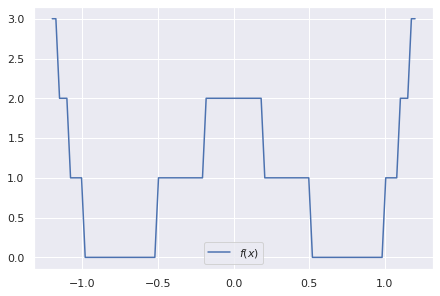

In [ ]:
# Define the piece-wise constant function f(x)
def stair_case_function(x: chex.Array) -> chex.Array:
    p = jnp.poly(-jnp.array([-1, -0.5, 0.5, 1]))
    smooth = jnp.polyval(p, x) / 0.2
    return jnp.ceil(smooth), smooth

# Create samples for the f(x) function between x values -1.2 and 1.2
x = np.linspace(-1.2, 1.2, 100)
y, ysmooth = stair_case_function(x)

# Preparing the training dataset
xtrain = np.random.uniform(low=x[0], high=x[-1], size=(128, 1))
ytrain, _ = stair_case_function(xtrain)

# Show the first 5 samples and the corresponding labels
print(xtrain[:5], ytrain[:5])

[[-0.40087595]
 [-0.43607905]
 [ 0.29376148]
 [-1.1912414 ]
 [ 0.56265697]] [[ 1.]
 [ 1.]
 [ 1.]
 [ 3.]
 [-0.]]


In [ ]:
# Create the NN model
@hk.transform
def nn(x):
    return hk.nets.MLP([16, 1], activation=jax.nn.tanh)(x)

rng = jax.random.PRNGKey(42)

params = nn.init(rng, xtrain)
opt = optax.adam(0.01)

opt_state = opt.init(params)

def loss(params, x, y):
    yhat = nn.apply(params, None, x)
    return jnp.mean(optax.l2_loss(yhat, y))

grad_loss = jax.jit(jax.grad(loss))

@jax.jit
def step(params, opt_state, x, y):
    grads = jax.grad(loss)(params, xtrain, ytrain)
    updates, opt_state = opt.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state

# Training
for _ in range(1000):
    params, opt_state = step(params, opt_state, xtrain, ytrain)


# %%
@jax.jit
def grad_fn(params, rng, x):
    @functools.partial(jax.vmap, in_axes=(0, None, None))
    @jax.grad
    def fn(x, params, rng):
        return nn.apply(params, rng, jnp.expand_dims(x, 0))[0]

    return fn(x, params, rng)

/usr/local/lib/python3.7/dist-packages/haiku/_src/base.py:497: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  param = init(shape, dtype)
/usr/local/lib/python3.7/dist-packages/haiku/_src/data_structures.py:144: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, treedef = jax.tree_flatten(tree)
/usr/local/lib/python3.7/dist-packages/haiku/_src/data_structures.py:145: FutureWarning: jax.tree_unflatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_unflatten instead.
  return jax.tree_unflatten(treedef, leaves)


The NN is differentiable, so we can surrogate the objective gradient by the gradient of the approximation $\nabla \hat f(x)$ in gradient descent. Notice that the sign of the surrogate gradient shows the correct monotonicity of the function.

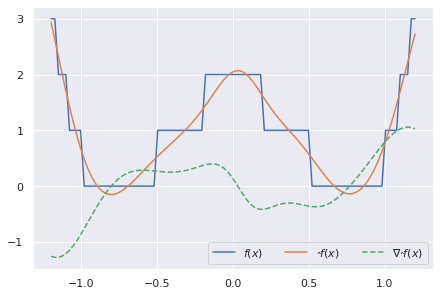

In [ ]:
# Make inference with trained NN and compute the gradients
yhat = nn.apply(params, rng, x[..., np.newaxis])[:, 0]
grads = grad_fn(params, rng, x)

fig, ax = plt.subplots( constrained_layout=True)

sns.lineplot(x=x, y=y, label='$f(x)$', ax=ax)
sns.lineplot(x=x, y=yhat, label='$\hat f(x)$', ax=ax)
ax = sns.lineplot(x=x, y=0.1 * grads, label=r'$\nabla \hat f(x)$', ax=ax)
ax.lines[2].set_linestyle("--")
plt.legend(ncol=3)

In [ ]:
point=jnp.array([[-1.1]])

@jax.jit
@jax.grad
def nabla(x):
  return nn.apply(params, rng, x).sum() #sum make it scalar


points=[point]
grads_list = list()

for _ in range(100):
  point = point - 0.001*nabla(point)
  points.append(point)
  grads_list.append(nabla(point)[0,0])

/usr/local/lib/python3.7/dist-packages/haiku/_src/data_structures.py:144: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, treedef = jax.tree_flatten(tree)
/usr/local/lib/python3.7/dist-packages/haiku/_src/data_structures.py:145: FutureWarning: jax.tree_unflatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_unflatten instead.
  return jax.tree_unflatten(treedef, leaves)


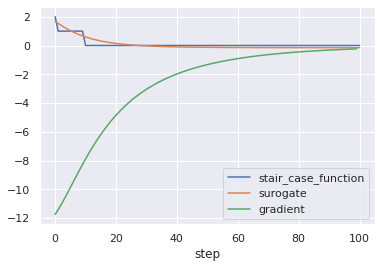

In [ ]:
surogates = np.asarray(nn.apply(params, rng, jnp.concatenate(points)))
plt.plot(stair_case_function(np.concatenate(points)[:,0])[0], label='stair_case_function')
plt.plot(surogates,label='surogate')
plt.plot(grads_list, label='gradient')
plt.xlabel('step')
plt.legend(loc="lower right")

# Inference on real network

In this section we are going to show how to load a pre-trained model and make a simple inference over a real-world network.

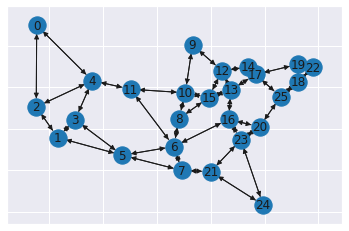

In [ ]:
# Load the real-world network
G = nx.read_graphml("janos-us.graphml")
G = nx.convert_node_labels_to_integers(G)
G = nx.DiGraph(G)
w = {k: 1. for k in G.edges}
nx.set_edge_attributes(G, w, name='weight')

all_pairs = dict(nx.all_pairs_dijkstra_path(G, weight='weight'))
G.graph['all_pairs']=all_pairs
pos =  {k:[float(v['x']),float(v['y'])] for k,v in G.nodes.data()}
nx.draw_networkx(G, pos=pos)

## Utility functions

In [ ]:
def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = it.tee(iterable)
    next(b, None)
    return zip(a, b)

def to_jraph(G:nx.Graph, src:int, dst:int)->Tuple[jraph.GraphsTuple, chex.Array]:
        nnodes = len(G)
        routing = G.graph['all_pairs']
        ledges = list(G.edges)
        relation_data = np.array(list(G.edges.data('weight')))

        nodes = np.zeros((nnodes, 2))
        nodes[src, 0] = 1
        nodes[dst, 1] = 1
        nodes = jnp.array(nodes)


        senders, receivers = jnp.split(relation_data[:, :2].astype(np.int32), 2, 1)
        edges = jnp.array(relation_data[:, 2:])

        x = jraph.GraphsTuple(
            n_node=jnp.asarray([nodes.shape[0]]),
            n_edge=jnp.asarray([edges.shape[0]]),
            nodes=nodes,
            edges=edges,
            senders=senders.flatten(),
            receivers=receivers.flatten(),
            globals=None
        )
        y = np.zeros((relation_data.shape[0],1))

        path = [ledges.index(e) for e in pairwise(routing[src][dst])]
        y[path,0] = 1
        return x,y

## The model

Our model maps a weighted graph to a soft routing representing the probabilities that each link belongs to the shortest path between two given nodes.

In [ ]:
NUM_LAYERS = 2  # Hard-code number of layers in the edge/node/global models.
LATENT_SIZE = 128  # Hard-code latent layer sizes for demos.


class MLPModule(hk.Module):
  def __call__(self, x, is_training=False)->jnp.ndarray:
    x=hk.nets.MLP([LATENT_SIZE] * NUM_LAYERS,activate_final=True)(x)
    x = hk.LayerNorm(axis=1, create_offset=True, create_scale=True)(x)
    return x


def network_definition(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
    latent = jraph.GraphMapFeatures(MLPModule(), MLPModule())(graph)
    latent0 = latent
    outputs = []

    core = jraph.GraphNetwork(
        update_edge_fn=jraph.concatenated_args(MLPModule()),
        update_node_fn=jraph.concatenated_args(MLPModule())
    )
    decoder = jraph.GraphMapFeatures(MLPModule(), MLPModule())

    output_transform = jraph.GraphMapFeatures(
        embed_edge_fn=hk.Linear(1)
    )

    num_message_passing_steps = 8
    for _ in range(num_message_passing_steps):
        core_input = latent._replace(
            nodes=jnp.concatenate((latent.nodes, latent0.nodes), axis=1),
            edges=jnp.concatenate((latent.edges, latent0.edges), axis=1)
        )
        latent = core(core_input)
        decoded = decoder(latent)
        outputs.append(output_transform(decoded))

    return outputs

Let's load a pretrained model as training from scratch would take ~30 min. Below we provide a small example of how to train the model from scratch.

In [ ]:
with open('net2vec/routing_by_backprop/log/labsim/sp1/snapshot-8000.pickle', 'rb') as f:
    params, state = pickle.load(f)

/usr/local/lib/python3.7/dist-packages/haiku/_src/data_structures.py:144: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, treedef = jax.tree_flatten(tree)
/usr/local/lib/python3.7/dist-packages/haiku/_src/data_structures.py:145: FutureWarning: jax.tree_unflatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_unflatten instead.
  return jax.tree_unflatten(treedef, leaves)


Now we can evaluate the model and compare its prediction with Dijkstra algorithm

In [ ]:
# Specify the src and destination nodes 
src = 0
dst = 7

x,y = to_jraph(G,src,dst)

In [ ]:
network = hk.without_apply_rng(hk.transform_with_state(network_definition))
hats, _ = network.apply(params, state, x)

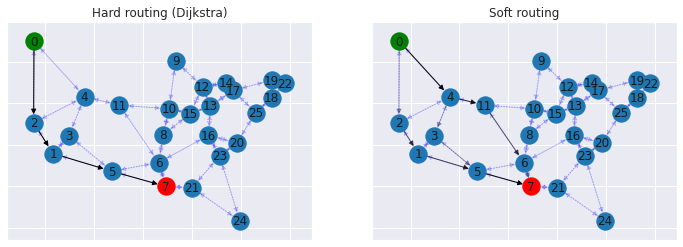

In [ ]:
p = jax.nn.sigmoid(hats[-1].edges)
fig,axs = plt.subplots(ncols=2,figsize=(12,4))

spl = list(pairwise(G.graph['all_pairs'][src][dst]))

def plot_route(G, pos, alpha, ax):
    nx.draw_networkx_nodes(G, pos, nodelist=set(G.nodes).difference(set([src,dst])),ax=ax)
    nx.draw_networkx_nodes(G, pos, nodelist=[src],node_color='green',ax=ax)
    nx.draw_networkx_nodes(G, pos, nodelist=[dst],node_color='red',ax=ax)
    nx.draw_networkx_edges(G,pos,edge_color='blue', alpha=0.2,ax=ax,style=':');
    nx.draw_networkx_edges(G,pos,edge_color=[(0.,0.,0.,np.asarray(a)) for a in alpha],ax=ax);
    nx.draw_networkx_labels(G,pos,ax=ax);

spl = list(pairwise(G.graph['all_pairs'][src][dst]))
alpha=[float(e in spl) for e in G.edges]

plot_route(G,pos,alpha,axs[0])
axs[0].set_title('Hard routing (Dijkstra)');
plot_route(G,pos,p.flatten(),axs[1])
axs[1].set_title('Soft routing');

# Optimizing a real network

In this section we show how to optimize a real-world network. To do this, we need to evaluate our model for all possible source-destination node pairs. For each pair, the link weights are going to be updated, optimizing the maximum link utilization. An efficient implementation is obtained by `vmap` transformation.

In [ ]:
def apply_for_pair(w: jnp.array, src: jnp.array, dst: jnp.array, params: hk.Params, state: hk.State,
                   graph_template: jraph.GraphsTuple) -> jnp.array:
    nodes = jnp.zeros_like(graph_template.nodes)
    nodes = nodes.at[src, 0].set(1)
    nodes = nodes.at[dst, 1].set(1)
    graph = graph_template._replace(nodes=nodes)
    graph = graph._replace(edges=w)
    hats, _ = network.apply(params, state, graph)
    return jax.nn.sigmoid(hats[-1].edges.flatten())

apply_for_graph = jax.vmap(apply_for_pair, in_axes=(None, 0, 0, None, None, None))

temperature = 0.1

@jax.jit
def cost_fn(x:jnp.ndarray)->float:
    '''Smooth approximation to max function'''
    scaled_x = x/temperature
    return temperature*jnp.dot(jax.nn.softmax(scaled_x),scaled_x)


def cost(w: jnp.array, src: jnp.array, dst: jnp.array, params: hk.Params, state: hk.State,
         graph_template: jraph.GraphsTuple, tm: jnp.array) -> jnp.array:
    p = apply_for_graph(w, src, dst, params, state, graph_template)
    flat_tm = tm[src, dst]
    link_traffic = flat_tm @ p
    return cost_fn(link_traffic)

def true_cost(H: nx.DiGraph, tm: np.array, src: np.array, dst: np.array, x: jraph.GraphsTuple, w: np.array):
    '''
    Compute true cost without any soft approximation
    :param H: topology
    :param tm: traffic matrix
    :param src: sender indices
    :param dst: receiver indices
    :param x: template graph
    :param w: weights
    :return: max load
    '''
    edge_attributes = {(int(s), int(r)): float(aw) for s, r, aw in zip(x.senders, x.receivers, w)}
    nx.set_edge_attributes(H, edge_attributes, 'weight')
    all_pairs = dict(nx.all_pairs_dijkstra_path(H, weight='weight'))

    hard_routing = []
    ledges = list(H.edges)
    for sd in zip(src, dst):
        s,d = jax.tree_map(int,sd)
        row = np.zeros(w.shape[0])
        path = [ledges.index(e) for e in pairwise(all_pairs[s][d])]
        row[path] = 1
        hard_routing.append(row)

    hard_routing = np.stack(hard_routing, axis=0)
    flat_tm = tm[src, dst]
    link_traffic = flat_tm @ hard_routing
    th = float(np.max(link_traffic))

    return th

@jax.jit
def update(w: jnp.array, src: jnp.array, dst: jnp.array, params: hk.Params, state: hk.State,
         graph_template: jraph.GraphsTuple, tm: jnp.array,lr: chex.Array) -> jnp.array:
    '''Gradient descent update   constrained to positive link weights'''
    grads = jax.grad(cost)(w, src, dst, params, state, graph_template, tm)
    proposal = w - lr*grads
    proposal = jnp.where(proposal < 0, 3*lr, proposal)
    return proposal

Neural network builds differentiable surrogate for discrete Dijkstra algorithm. Let's  explore the gradient of the approximation to minimize the objective TE function.

In [ ]:
n = len(G)

print("Num nodes:", n)
print("Num edges:", len(G.edges))

srcu, dstu = np.triu_indices(n, k=1)
srcl, dstl = np.tril_indices(n, k=-1)

src = jnp.concatenate([srcu, srcl], axis=0)
dst = jnp.concatenate([dstu, dstl], axis=0)

# This controls congestion level
tmscale = 0.6

# Link weights are all initialized to 1
w = jnp.ones_like(x.edges)
tm = tmscale * np.random.uniform(0.0, 1.0, size=(n, n)) / (n - 1)

H = G.copy()

initialcost = true_cost(H, tm, src, dst, x, w)
result = dict(
            initialcost=initialcost,
        )

lr = 2e-2

# Run 3 optimization steps
for i in range(3):
    w = update(w, src, dst, params, state, x, tm,lr)
    result[f'finalcost_{i}'] = true_cost(H, tm, src, dst, x, w)

w=w.block_until_ready()

result

{'initialcost': 1.0479357359916401,
 'finalcost_0': 0.8055977515045523,
 'finalcost_1': 0.8055977515045523,
 'finalcost_2': 0.8055977515045523}

Notice how the ***true*** maximum load is reduced.

# Trainig the model

Suppose you want to train the model from scratch. Below we show a brief introduction of how we trained it. Note that this is code is only for didactic purpose and it's not the most efficient implementation. For our real code check the repository [routing_by_backprop](https://github.com/krzysztofrusek/net2vec/tree/master/routing_by_backprop).

In [ ]:
from scipy.stats import beta

def random_beta_w(G: nx.Graph) -> np.ndarray:
    # random weights 0.5, 1.5 with mode at 1
    w_dist = beta(a=10, b=10, scale=2)
    w = w_dist.rvs(len(G.edges))
    return w

def _nearest_bigger_power_of_two(x: int) -> int:
    """Computes the nearest power of two greater than x for padding.
    Idea taken from:
    https://github.com/deepmind/jraph/blob/master/jraph/ogb_examples/train_flax.py
    """
    y = 2
    while y < x:
        y *= 2
    return y

def data_fn(steps=10):
  for _ in range(steps):
    G = nx.barabasi_albert_graph(16,2)
    G = nx.convert_node_labels_to_integers(G)
    G = nx.DiGraph(G)
    w = {k: ww for k,ww in zip(G.edges,random_beta_w(G))}
    nx.set_edge_attributes(G, w, name='weight')

    all_pairs = dict(nx.all_pairs_dijkstra_path(G, weight='weight'))
    G.graph['all_pairs']=all_pairs

    nnodes = len(G)
    src, dst = np.random.choice(nnodes, 2, replace=False)

    x,y = to_jraph(G,src,dst)

    # Add 1 since we need at least one padding node for pad_with_graphs.
    pad_nodes_to = _nearest_bigger_power_of_two(jnp.sum(x.n_node)) + 1
    pad_edges_to = _nearest_bigger_power_of_two(jnp.sum(x.n_edge))
    # Add 1 since we need at least one padding graph for pad_with_graphs.
    # We do not pad to nearest power of two because the batch size is fixed.
    pad_graphs_to = x.n_node.shape[0] + 1

    pbx = jraph.pad_with_graphs(x,
                                          n_node=pad_nodes_to,
                                          n_edge=pad_edges_to,
                                          n_graph=pad_graphs_to)
    pby = jnp.pad(y,((0,pad_edges_to-y.shape[0]),(0,0)))

    yield pbx,pby

In [ ]:
for x,y in data_fn():
  break

The *node* features are represented by a one-hot vector of size 2: 



1.   $[0,0]$ not used
2.   $[1,0]$ source
3.   $[0,1]$ destination

In [ ]:
print(x.nodes)

[[0. 0.]
 [0. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


The *edge* features indicate the weights used in the Dijkstra algorithm. Notice that some values are 0 because they are padded as XLA works with static shapes.

In [ ]:
print(x.edges)

[[0.7864701 ]
 [1.1090951 ]
 [0.7248116 ]
 [0.6452629 ]
 [0.92690367]
 [1.0975343 ]
 [1.3076893 ]
 [0.7435798 ]
 [1.3075511 ]
 [1.0280837 ]
 [1.0992296 ]
 [1.1906242 ]
 [1.5735174 ]
 [1.0985241 ]
 [1.0040736 ]
 [1.291948  ]
 [0.5331162 ]
 [0.57096744]
 [1.0481824 ]
 [0.6160452 ]
 [0.8359031 ]
 [1.3763239 ]
 [1.2620989 ]
 [0.7235914 ]
 [0.5866209 ]
 [1.0458976 ]
 [0.51487595]
 [1.319676  ]
 [1.1214187 ]
 [0.97242135]
 [1.285441  ]
 [0.75857484]
 [0.93694824]
 [1.2245601 ]
 [1.1816072 ]
 [0.7320108 ]
 [1.2614944 ]
 [0.7291986 ]
 [0.7906138 ]
 [0.9247765 ]
 [1.2232394 ]
 [1.04055   ]
 [0.9684571 ]
 [0.56789637]
 [0.84254557]
 [1.0287862 ]
 [0.8344832 ]
 [0.8182591 ]
 [0.8067121 ]
 [0.8295423 ]
 [1.0590535 ]
 [0.69329035]
 [0.96840906]
 [0.6502565 ]
 [0.92289656]
 [0.93396974]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]]


The label or *y* is a binary vector indicating the links that are part of the Dijkstra shortest path between the source and destination nodes.

In [ ]:
print(y)

[[1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


In [ ]:
from typing import Tuple,Any

@functools.partial(jax.jit, static_argnums=4) #4th argument is static
def loss(params: hk.Params, state: hk.State, x:jraph.GraphsTuple, y:jnp.ndarray, is_training=True) -> Tuple[Any, Any]:
    hats, state = network.apply(params, state, x)
    mask = jraph.get_edge_padding_mask(x)[..., jnp.newaxis]

    losses = [jnp.mean(optax.sigmoid_binary_cross_entropy(hat.edges, y), where=mask) for hat in hats]
    final_loss = sum(losses)/len(losses) if is_training else losses[-1]
    return final_loss, state

@jax.jit
def update(params, state, opt_state, x,y):
    (l, s), grads = jax.value_and_grad(loss, has_aux=True)(params, state, x,y, True)
    updates, new_opt_state = opt.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return l, s, new_params, new_opt_state

In [ ]:
losses=[]

params, state = network.init(jax.random.PRNGKey(42), x)
opt = optax.adam(learning_rate=0.001)
opt_state = opt.init(params)

for x,y in data_fn(256):
  l, state, params, opt_state = update(params, state, opt_state, x,y)
  losses.append(l)

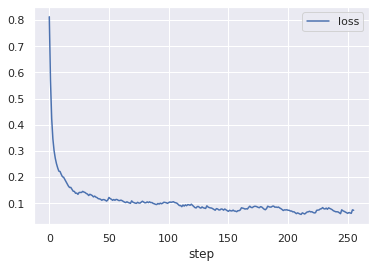

In [ ]:
import pandas as pd
pd.DataFrame(dict(loss=np.concatenate([losses]))).ewm(span = 32).mean().plot()
plt.xlabel('step');